In [ ]:
# Define the output file name
output_file = "consolidated_data.csv"

# Initialize a list to store merged DataFrames from all subfolders
all_subfolder_data = []

# Traverse through all subfolders in the current directory
for root, dirs, files in os.walk(os.getcwd()):
    infotable_df = None
    coverpage_df = None
    print(root)

    for file in files:
        file_path = os.path.join(root, file)

        # Process INFOTABLE.tsv
        if file == "INFOTABLE.tsv":
            try:
                print(f"Processing: {file_path}")
                infotable_df = pd.read_csv(file_path, sep="\t", low_memory=False)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

        # Process COVERPAGE.tsv
        if file == "COVERPAGE.tsv":
            try:
                print(f"Processing: {file_path}")
                coverpage_df = pd.read_csv(file_path, sep="\t", low_memory=False)
                # Keep only necessary columns
                coverpage_df = coverpage_df[["ACCESSION_NUMBER", "FILINGMANAGER_NAME", "DATEREPORTED"]]
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    # Merge INFOTABLE and COVERPAGE on ACCESSION_NUMBER if both are present
    if infotable_df is not None and coverpage_df is not None:
        try:
            merged_subfolder_data = pd.merge(infotable_df, coverpage_df, on="ACCESSION_NUMBER", how="inner")
            all_subfolder_data.append(merged_subfolder_data)
        except Exception as e:
            print(f"Error merging files in {root}: {e}")

# Combine all merged subfolder DataFrames into a single DataFrame
if all_subfolder_data:
    consolidated_data = pd.concat(all_subfolder_data, ignore_index=True)
    consolidated_data.to_csv(output_file, index=False)
    print(f"Consolidation complete. File saved as {output_file}")
else:
    print("No data to process.")
    



In [ ]:
# Import the pandas library
import pandas as pd

# Function to check and print the fields of a CSV file
def check_csv_fields(file_path):
    """
    Load a CSV file and print its fields (column names) along with metadata.

    Args:
        file_path (str): Path to the CSV file.
    """
    try:
        # Load CSV into a DataFrame without loading all data into memory
        df = pd.read_csv(file_path, nrows=0)

        # Print column names
        print("Field (Column) Names:")
        for column in df.columns:
            print(f"- {column}")

        # Print metadata
        print(f"\nNumber of fields: {len(df.columns)}")

    except Exception as e:
        print(f"Error loading CSV file: {e}")

# Example usage
# Replace 'your_file.csv' with the path to your CSV file
check_csv_fields('consolidated_data_2.csv')


In [ ]:
import pandas as pd

def delete_fields_from_csv(input_file, output_file, fields_to_delete):
    """
    Deletes specified fields (columns) from a CSV file and saves the updated data to a new file.

    Args:
        input_file (str): Path to the input CSV file.
        output_file (str): Path to save the updated CSV file.
        fields_to_delete (list): List of column names to delete from the CSV.

    Returns:
        None
    """
    try:
        # Load the CSV file
        df = pd.read_csv(input_file)

        # Check if the columns to delete exist in the DataFrame
        missing_fields = [field for field in fields_to_delete if field not in df.columns]
        if missing_fields:
            print(f"Warning: The following fields were not found in the CSV and will be ignored: {missing_fields}")

        # Drop the specified fields
        updated_df = df.drop(columns=fields_to_delete, errors='ignore')

        # Save the updated DataFrame to a new CSV file
        updated_df.to_csv(output_file, index=False)
        print(f"Updated CSV saved to '{output_file}'.")

    except Exception as e:
        print(f"Error processing the file: {e}")

# Example usage
input_file = 'consolidated_data_2.csv'  # Replace with your input file path
output_file = 'final_13f.csv'  # Replace with your desired output file path
fields_to_delete = ['ACCESSION_NUMBER']  # Replace with the fields/columns you want to delete

delete_fields_from_csv(input_file, output_file, fields_to_delete)

In [ ]:
import pandas as pd

class YourClass:
    input_path = "final_13f.csv"

    def CUSIP_to_ticker(self, output_csv_path="institutional_data.csv"):
        """
        Reads institutional data, maps CUSIP codes to tickers using a reference CSV,
        removes invalid dates, and writes the resulting DataFrame to a CSV file.

        Args:
            output_csv_path (str): Path to save the resulting CSV file.

        Returns:
            str: Path to the generated CSV file.
        """
        # Reference CSV for CUSIP-to-Ticker mapping
        df_ref = pd.read_csv("cusip_tickers.csv", dtype=str)

        # Check if required columns exist
        if not {"CUSIP", "Ticker"}.issubset(df_ref.columns):
            raise ValueError("Reference CSV must have 'CUSIP' and 'Ticker' columns.")

        # Create a mapping dictionary
        cusip_to_ticker = df_ref.set_index("CUSIP")["Ticker"].to_dict()

        original_csv = self.input_path  # Path to the input file
        chunksize = 10**5  # Process data in chunks of 100,000 rows

        # Open the output file in write mode
        with pd.read_csv(original_csv, dtype=str, chunksize=chunksize) as reader, open(output_csv_path, "w") as output_file:
            for chunk_index, chunk in enumerate(reader):
                print(f"Processing chunk {chunk_index + 1}...")

                # Validate required columns
                if "CUSIP" not in chunk.columns or "DATEREPORTED" not in chunk.columns:
                    raise ValueError("Input CSV is missing 'CUSIP' or 'DATEREPORTED' columns.")

                # Map CUSIP to Ticker
                chunk["CUSIP"] = chunk["CUSIP"].map(cusip_to_ticker).fillna(chunk["CUSIP"])

                # Rename 'CUSIP' column to 'Ticker'
                chunk.rename(columns={"CUSIP": "Ticker", "DATEREPORTED": "date"}, inplace=True)

                # Convert 'date' column to datetime and drop invalid dates
                chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
                chunk.dropna(subset=["date"], inplace=True)  # Remove rows with invalid dates

                # Debugging: Print the first few rows of the current chunk
                print(chunk.head())

                # Write the processed chunk to the output CSV
                mode = "w" if chunk_index == 0 else "a"  # Write header only for the first chunk
                header = chunk_index == 0
                chunk.to_csv(output_file, index=False, mode=mode, header=header)

        print(f"Consolidated data has been saved to {output_csv_path}")
        return output_csv_path


# Create an instance of YourClass and call the method
analyzer = YourClass()
output_csv_path = analyzer.CUSIP_to_ticker()
print(f"Output CSV generated at: {output_csv_path}")


In [ ]:
# Old code

"""
df_ref = pd.read_csv("cusip_tickers.csv", dtype=str)
cusip_to_ticker = df_ref.set_index("CUSIP")["Ticker"].to_dict()

# Check columns exist
if not {"CUSIP", "Ticker"}.issubset(df_ref.columns):
    raise ValueError("Reference CSV must have 'CUSIP' and 'Ticker' columns.")
    
# Convert to dict
   
def process_dataframe(df, cusip_to_ticker):
    """
    Maps CUSIP codes to tickers within a DataFrame and renames the column.

    Args:
        df (pd.DataFrame): The original DataFrame with a 'CUSIP' column.
        cusip_to_ticker (dict): Dictionary mapping CUSIP codes to tickers.

    Returns:
        pd.DataFrame: The updated DataFrame with 'CUSIP' replaced by 'Ticker'.
    """
    # Check if "CUSIP" exists in the DataFrame
    if "CUSIP" not in df.columns:
        raise ValueError("The DataFrame is missing a 'CUSIP' column.")

    # Map CUSIP to Ticker and handle missing mappings
    df["CUSIP"] = df["CUSIP"].map(cusip_to_ticker).fillna(df["CUSIP"])

    # Rename "CUSIP" column to "Ticker"
    df.rename(columns={"CUSIP": "Ticker"}, inplace=True)

    return df


# Process the DataFrame
processed_df = process_dataframe(df, cusip_to_ticker)

print(processed_df)
      
    """
    

In [2]:
import os
import pandas as pd
from sec_cik_mapper import StockMapper

mapper = StockMapper()
# Define the parent directory to process
def process_googl_holdings(parent_directory):
    result_data = []  # To store filtered and aggregated data

    # Define GOOGL CUSIP
    googl_cusip1 = "02079K305"
    googl_cusip2 = "02079K107"

    # Walk through all subfolders
    for root, dirs, files in os.walk(parent_directory):
        info_table_path = None
        submission_path = None

        # Identify required files in the current directory
        for file in files:
            if file.lower() == "infotable.tsv":
                info_table_path = os.path.join(root, file)
            elif file.lower() == "submission.tsv":
                submission_path = os.path.join(root, file)

        # If both files are found, process them
        if info_table_path and submission_path:
            # Load INFO TABLE
            try:
                info_table_df = pd.read_csv(info_table_path, sep="\t")
                # Filter for GOOGL holdings
                googl_holdings1 = info_table_df[info_table_df["CUSIP"] == googl_cusip1]
                googl_holdings2 = info_table_df[info_table_df["CUSIP"] == googl_cusip2]
                googl_holdings = pd.concat([googl_holdings1, googl_holdings2], ignore_index=True)
                # print(info_table_df)
                if googl_holdings.empty:
                    continue  # Skip if no GOOGL holdings found
            except Exception as e:
                print(f"Error reading INFO TABLE at {info_table_path}: {e}")
                continue

            # Load SUBMISSION
            try:
                submission_df = pd.read_csv(submission_path, sep="\t")
                # print(submission_df)
                # Join INFO TABLE with SUBMISSION on accession number
                if "ACCESSION_NUMBER" in info_table_df.columns and "ACCESSION_NUMBER" in submission_df.columns:
                    googl_holdings = googl_holdings.merge(
                        submission_df, on="ACCESSION_NUMBER", how="inner"
                    )
            except Exception as e:
                print(f"Error reading SUBMISSION at {submission_path}: {e}")
                continue

            # Combine GOOGL holdings with submission metadata
            try:
                for _, row in googl_holdings.iterrows():
                    combined_data = {
                        "issuer_name": row.get("NAMEOFISSUER"),
                        "cusip": row.get("CUSIP"),
                        "value": row.get("VALUE"),
                        "shares": row.get("SSHPRNAMT"),
                        "share_type": row.get("SSHPRNAMTTYPE"),
                        "put_call": row.get("PUTCALL", None),
                        "submission_cik": row.get("CIK"),
                        "submission_ticker": mapper.cik_to_tickers.get(str(row.get("CIK")).zfill(10), None),
                        "submission_form_type": row.get("SUBMISSIONTYPE"),
                        "submission_period": row.get("PERIODOFREPORT"),
                        "submission_filing_date": row.get("FILING_DATE"),
                    }
                    result_data.append(combined_data)

            except Exception as e:
                print(f"Error processing data from {info_table_path} and {submission_path}: {e}")
                continue

    # Create final DataFrame
    result_df = pd.DataFrame(result_data)

    # Save the filtered and aggregated data to a CSV file
    output_path = os.path.join(parent_directory, "googl_holdings_aggregated.csv")
    result_df.to_csv(output_path, index=False)
    print(f"Filtered GOOGL holdings data saved to {output_path}")

# Specify the parent directory (replace this with the actual path)
parent_directory = "/Users/lockin/Downloads/"
process_googl_holdings(parent_directory)


/var/folders/26/yfv_whfd2pv776k5pk93tvt80000gn/T/ipykernel_4738/3946070976.py:30: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  info_table_df = pd.read_csv(info_table_path, sep="\t")
/var/folders/26/yfv_whfd2pv776k5pk93tvt80000gn/T/ipykernel_4738/3946070976.py:30: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  info_table_df = pd.read_csv(info_table_path, sep="\t")
/var/folders/26/yfv_whfd2pv776k5pk93tvt80000gn/T/ipykernel_4738/3946070976.py:30: DtypeWarning: Columns (5,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  info_table_df = pd.read_csv(info_table_path, sep="\t")
/var/folders/26/yfv_whfd2pv776k5pk93tvt80000gn/T/ipykernel_4738/3946070976.py:30: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  info_table_df = pd.read_csv(info_table_path, sep="\t")
/var/folders/26/yfv_whfd2pv776k5pk9

Filtered GOOGL holdings data saved to /Users/lockin/Downloads/googl_holdings_aggregated.csv


In [6]:

mapper.cik_to_tickers
mapper = StockMapper()
cik_to_ticker = mapper.cik_to_tickers  
cik_to_ticker.get(str(1750).zfill(10))# Dictionary mapping CIK to tickers

{'AIR'}

In [ ]:
import pandas as pd

# Load the dataset
def analyze_cik_holdings(file_path, output_path):
    # Load the data
    df = pd.read_csv(file_path)

    # Convert submission_period to datetime for quarter-based grouping
    df['submission_period'] = pd.to_datetime(df['submission_period'], format="%d-%b-%Y")

    # Extract year-quarter for grouping
    df['year_quarter'] = df['submission_period'].dt.to_period('Q')

    # Aggregate shares by CIK and year-quarter
    grouped = df.groupby(['submission_cik', 'year_quarter'])['shares'].sum().unstack(fill_value=0)

    # Create a DataFrame with percent changes for each quarter
    percent_changes = grouped.pct_change(axis=1) * 100

    # Fill missing percent changes with 0
    percent_changes = percent_changes.fillna(0)

    # Forward-fill missing values in the original data for accurate future changes
    grouped = grouped.fillna(method='ffill', axis=1)

    # Combine the original shares data with percent changes
    combined_df = pd.concat([grouped, percent_changes.add_suffix('_percent_change')], axis=1)

    # Save the result to a new CSV
    combined_df.reset_index().to_csv(output_path, index=False)
    print(f"Analysis saved to {output_path}")

# File paths
input_file_path = "./googl_holdings_aggregated1.csv"
output_file_path = "./cik_holdings_analysis.csv"

# Run the analysis
analyze_cik_holdings(input_file_path, output_file_path)


Analysis saved to ./cik_holdings_analysis.csv


/var/folders/26/yfv_whfd2pv776k5pk93tvt80000gn/T/ipykernel_7642/1413951334.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grouped = grouped.fillna(method='ffill', axis=1)


In [3]:
import pandas as pd

# Load the dataset
def analyze_googl_holdings(file_path, output_path):
    # Load the data
    df = pd.read_csv(file_path)

    # Convert submission_period to datetime for quarter-based grouping
    df['submission_period'] = pd.to_datetime(df['submission_period'], format="%d-%b-%Y")

    # Extract year-quarter for grouping
    df['year_quarter'] = df['submission_period'].dt.to_period('Q')

    # Aggregate total shares for all institutions by year-quarter
    aggregated = df.groupby('year_quarter')['shares'].sum()

    # Calculate quarter-over-quarter net change
    aggregated_changes = aggregated.diff().fillna(0)

    # Create a new DataFrame to store results
    results = pd.DataFrame({
        'year_quarter': aggregated.index,
        'total_shares': aggregated.values,
        'net_change': aggregated_changes.values,
        'percent_change': aggregated_changes / aggregated.shift(1).fillna(1) * 100
    })

    # Save the results to a new CSV
    results.to_csv(output_path, index=False)
    print(f"GOOGL holdings analysis saved to {output_path}")

# File paths
input_file_path = "./googl_holdings_aggregated1.csv"
output_file_path = "./googl_holdings_net_changes.csv"

# Run the analysis
analyze_googl_holdings(input_file_path, output_file_path)


GOOGL holdings analysis saved to ./googl_holdings_net_changes.csv


GOOGL holdings analysis saved to ./googl_holdings_net_changes.csv


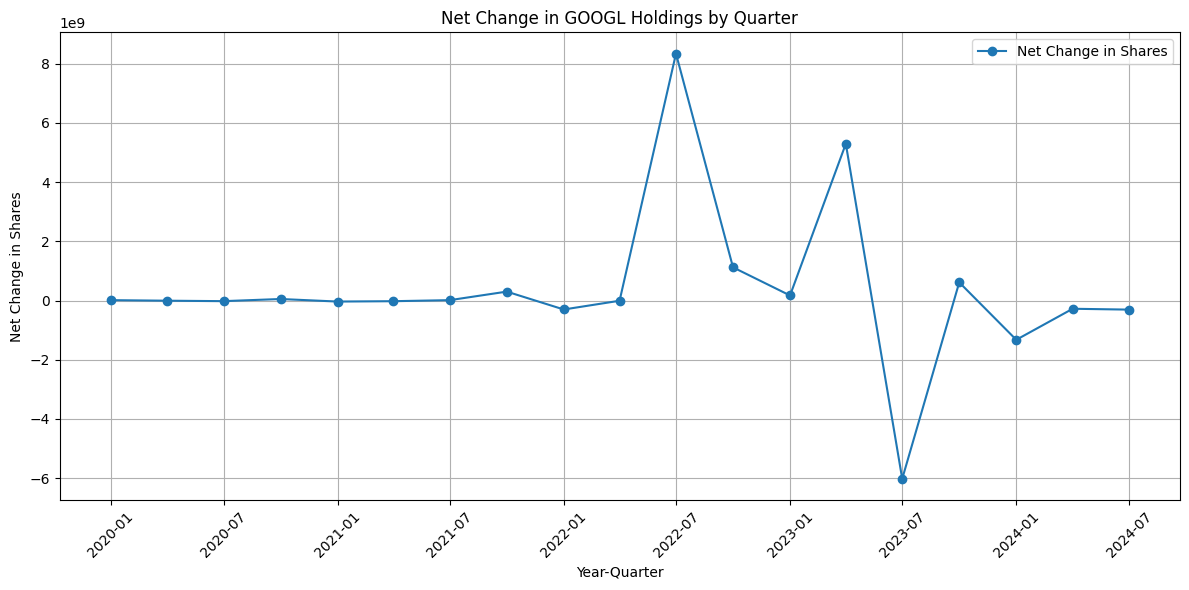

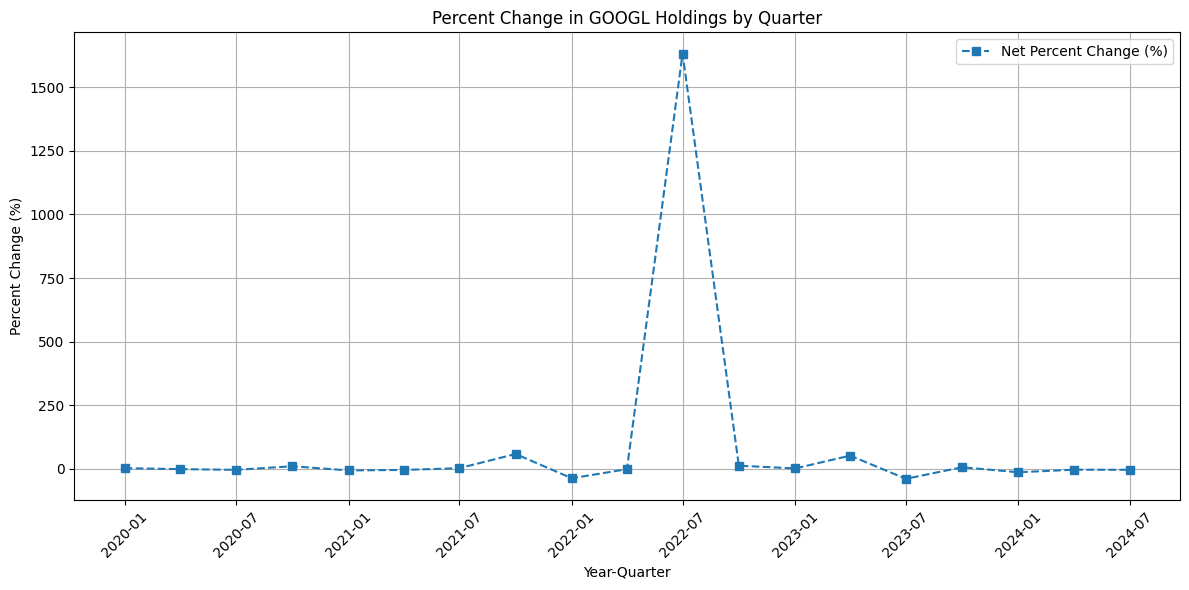

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and analyze holdings
def analyze_googl_holdings(file_path, output_path):
    # Load the data
    df = pd.read_csv(file_path)

    # Convert submission_period to datetime for quarter-based grouping
    df['submission_period'] = pd.to_datetime(df['submission_period'], format="%d-%b-%Y")

    # Extract year-quarter for grouping
    df['year_quarter'] = df['submission_period'].dt.to_period('Q')

    # Aggregate total shares for all institutions by year-quarter
    aggregated = df.groupby('year_quarter')['shares'].sum()

    # Calculate quarter-over-quarter net change
    aggregated_changes = aggregated.diff().fillna(0)

    # Create a new DataFrame to store results
    results = pd.DataFrame({
        'year_quarter': aggregated.index,
        'total_shares': aggregated.values,
        'net_change': aggregated_changes.values,
        'percent_change': aggregated_changes / aggregated.shift(1).fillna(1) * 100
    })

    # Save the results to a new CSV
    results.to_csv(output_path, index=False)
    print(f"GOOGL holdings analysis saved to {output_path}")

    # Return the results DataFrame for plotting
    return results
# Plot the net change results
def plot_net_change(results, start_year=2020):
    # Filter the data for the specified start year and onwards
    results['year_quarter'] = pd.PeriodIndex(results['year_quarter'], freq='Q').to_timestamp()
    filtered_results = results[results['year_quarter'] >= f'{start_year}-01-01']

    # Plot the net change data
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_results['year_quarter'], filtered_results['net_change'], label='Net Change in Shares', marker='o')

    # Add labels, legend, and title
    plt.xlabel('Year-Quarter')
    plt.ylabel('Net Change in Shares')
    plt.title('Net Change in GOOGL Holdings by Quarter')
    plt.legend()
    plt.grid(True)

    # Display the graph
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the percent change results
def plot_percent_change(results, start_year=2020):
    # Filter the data for the specified start year and onwards
    results['year_quarter'] = pd.PeriodIndex(results['year_quarter'], freq='Q').to_timestamp()
    filtered_results = results[results['year_quarter'] >= f'{start_year}-01-01']

    # Plot the percent change data
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_results['year_quarter'], filtered_results['percent_change'], label='Net Percent Change (%)', marker='s', linestyle='--')

    # Add labels, legend, and title
    plt.xlabel('Year-Quarter')
    plt.ylabel('Percent Change (%)')
    plt.title('Percent Change in GOOGL Holdings by Quarter')
    plt.legend()
    plt.grid(True)

    # Display the graph
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# File paths
input_file_path = "./googl_holdings_aggregated1.csv"
output_file_path = "./googl_holdings_net_changes.csv"

# Run the analysis
results = analyze_googl_holdings(input_file_path, output_file_path)

# Plot the results
# Plot the results
plot_net_change(results, start_year=2020)
plot_percent_change(results, start_year=2020)